In [ ]:
# ===========================
# 0. Install dependencies
# ===========================
!pip install -q scikit-learn pandas numpy matplotlib seaborn gensim umap-learn hdbscan bertopic[all] sentence-transformers Sastrawi spacy==3.5.0 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
!python -m spacy download xx_ent_wiki_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 32.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install gensim bertopic Sastrawi -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
# ===========================
# 1. Imports & konfigurasi dasar
# ===========================
import os, re, time, json
from pprint import pprint
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Sklearn & modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Evaluation
import gensim
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

# BERTopic & embeddings
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

# Utility
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

sns.set(style="whitegrid")
tqdm.pandas()

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# ===========================
# 2. Konfigurasi user
# ===========================
TEXT_COL = 'stemmed'
DOC_SAMPLE = None      # None = semua dokumen;
RANDOM_STATE = 42

# Topik default
DEFAULT_N_TOPICS = 5

# BERTopic settings
BER_TOPIC_SAMPLE = None    # None untuk semua dokumen;
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
UMAP_N_NEIGHBORS = 15
UMAP_N_COMPONENTS = 5
HDBSCAN_MIN_CLUSTER_SIZE = 50

# Vectorizer parameters (tweakable)
TFIDF_PARAMS = dict(max_df=0.85, min_df=10, ngram_range=(1,2), max_features=25000)
COUNT_PARAMS = dict(max_df=0.85, min_df=10, ngram_range=(1,2), max_features=25000)

# LDA grid (contoh)
LDA_GRID = {
    'n_components': [8, 10, 12],
    'learning_decay': [0.5, 0.7]
}

# Merge threshold (cosine sim between topic vectors) untuk menggabungkan topik yang sangat mirip
MERGE_SIM_THRESHOLD = 0.78

In [ ]:
# ===========================
# 3. Load dataframe
# ===========================
df = pd.read_csv('https://drive.google.com/uc?id=1KW1WDpM0cgZEKhI4QMJD-fGQW8JQso09')

print("Dataframe shape:", df.shape)
df = df.copy()
if DOC_SAMPLE is not None:
    df = df.sample(DOC_SAMPLE, random_state=RANDOM_STATE).reset_index(drop=True)

# Pastikan kolom ada
assert TEXT_COL in df.columns, f"Kolom {TEXT_COL} tidak ada di df"

documents_raw = df[TEXT_COL].astype(str).tolist()

Dataframe shape: (16142, 6)


In [ ]:
# ===========================
# 4. Preprocessing: cleaning + custom stopwords + optional NER entity removal
# ===========================
# 4.1 Stopwords dasar (Sastrawi) + custom domain stopwords dari analisis sebelumnya
factory = StopWordRemoverFactory()
stopwords_ind = set(factory.get_stop_words())

# Custom stopwords
custom_stop = {
    "kpk","bank","saham","uang","triliun","miliar","ppatk","partai","kasus","korupsi",
    "lapor","periksa","duga","sangka","pasal","pidana","presiden","jokowi","prabowo",
    "ag","david","mario","rf","rah","indonesia","jakarta","hari","perintah","masyarakat",
    "kata", "jadi", "orang", "bagai", "besar",

    # angka & unit umum
    "2023", "tahun", "rp", "persen", "per", "us",

    # istilah ekonomi terlalu generik
    "harga", "naik", "turun", "indeks", "pasar",

    # tokoh/entitas politik yang menyebabkan bias
    "mahfud", "rafael", "mulyani", "sri", "sri mulyani",
    "menteri", "pegawai", "kemenkeu",

    # kriminal dan kecelakaan spesifik
    "korban", "laku", "motor", "kendara",

    # isu mudik dan lebaran yang mendominasi
    "mudik", "lebaran", "thr", "puasa", "april",

    # impor barang bekas (muncul lintas topik)
    "bekas", "impor", "barang", "tiket",

    "dan", "atau", "tetapi", "namun", "karena", "bahwa", "sehingga", "maka",
    "jika", "ketika", "walaupun", "meski", "padahal", "selain", "serta",
    "di", "ke", "dari", "untuk", "pada", "dalam", "dengan", "tanpa",
    "terhadap", "antara", "kepada", "sekitar", "menuju",
    "lebih", "lalu", "sama", "satu", "banyak", "cara", "milik",
    "negara", "kemudian", "sudah", "masih", "dapat", "agar",
    "dua", "tiga", "20", "2023", "tahun",
    'sebut', 'kerja', 'usaha', 'jalan', 'beri', 'temu', 'baik', 'kait', 'hingga', 'anak', 'hadap', 'ganjar', 'anies'
}
stopwords_ind |= custom_stop

# 4.2 Simple NER-based entity removal (opsional) - menggunakan spaCy multilingual
nlp = spacy.load("xx_ent_wiki_sm")  # ringan, deteksi entitas umum
def remove_entities_spacy(text, entity_types_to_remove=None):
    if not text:
        return text
    doc = nlp(text)
    if entity_types_to_remove is None:
        # default: PERSON, ORG, GPE, LOC
        entity_types_to_remove = {"PERSON","ORG","GPE","LOC"}
    tokens = []
    ent_positions = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.label_ in entity_types_to_remove]
    if not ent_positions:
        return text
    # replace entities with space
    out = text
    for s,e in sorted(ent_positions, reverse=True):
        out = out[:s] + " " + out[e:]
    return out

# 4.3 Preprocess pipeline
def preprocess_text(text, do_entity_removal=False):
    t = str(text).lower()
    t = re.sub(r'http\S+|www\S+',' ', t)
    t = re.sub(r'[^0-9a-z\s]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    if do_entity_removal:
        t = remove_entities_spacy(t)
    tokens = [w for w in t.split() if w not in stopwords_ind and len(w) > 1]
    return " ".join(tokens)

# Terapkan preprocessing
print("Preprocessing texts...")
docs_clean = [preprocess_text(d, do_entity_removal=False) for d in tqdm(documents_raw)]

# Tokenized texts for gensim
tokenized_texts = [doc.split() for doc in docs_clean]

# Build gensim dictionary
id2word = corpora.Dictionary(tokenized_texts)
id2word.filter_extremes(no_below=5, no_above=0.85)
corpus_gensim = [id2word.doc2bow(text) for text in tokenized_texts]

Preprocessing texts...


  0%|          | 0/16142 [00:00<?, ?it/s]

In [ ]:
# ===========================
# 5. Vectorizers fit
# ===========================
tfidf_vectorizer = TfidfVectorizer(**TFIDF_PARAMS)
count_vectorizer = CountVectorizer(**COUNT_PARAMS)

print("Fitting TF-IDF and Count vectorizers...")
X_tfidf = tfidf_vectorizer.fit_transform(docs_clean)
X_count = count_vectorizer.fit_transform(docs_clean)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
feature_names_count = count_vectorizer.get_feature_names_out()
print("Shapes:", X_tfidf.shape, X_count.shape)

Fitting TF-IDF and Count vectorizers...
Shapes: (16142, 25000) (16142, 25000)


In [ ]:
# ===========================
# 6. Helper functions
# ===========================
def get_top_n_words_from_components(components, feature_names, top_n=12):
    topics = []
    for idx, comp in enumerate(components):
        top_idx = comp.argsort()[::-1][:top_n]
        top_words = [feature_names[i] for i in top_idx]
        topics.append((idx, top_words))
    return topics

def print_topics(topics):
    for idx, words in topics:
        print(f"Topic {idx}: " + ", ".join(words))

def coherence_score_from_topics(topic_words, texts, dictionary, coherence='c_v'):
    """topic_words: list of list of words"""
    cm = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence=coherence)
    return cm.get_coherence()

def export_topic_doc_mapping(model_name, doc_topic_dist, docs_df, outpath):
    """
    doc_topic_dist: array-like shape (n_docs,) of assigned topic ids
    """
    df_map = docs_df.copy()
    df_map['predicted_topic'] = doc_topic_dist
    df_map.to_csv(outpath, index=False)
    print(f"Saved mapping to {outpath}")
    return df_map

In [ ]:
# ===========================
# 7. LSA pipeline (TF-IDF + TruncatedSVD)
# ===========================
def run_lsa(docs, vectorizer, n_topics=DEFAULT_N_TOPICS):
    print(f"Running LSA with n_topics={n_topics}")
    svd = TruncatedSVD(n_components=n_topics, random_state=RANDOM_STATE)
    X = vectorizer.transform(docs)  # vectorizer already fit
    X_svd = svd.fit_transform(X)
    # normalize components for cosine similarity later
    topics = get_top_n_words_from_components(svd.components_, vectorizer.get_feature_names_out(), top_n=12)
    topic_words = [words for _, words in topics]
    coherence = coherence_score_from_topics(topic_words, tokenized_texts, id2word)
    return {
        'model': svd,
        'doc_topic_matrix': X_svd,     # note: these are SVD latent coords
        'topics': topics,
        'topic_words': topic_words,
        'coherence': coherence
    }

lsa_res = run_lsa(docs_clean, tfidf_vectorizer, n_topics=DEFAULT_N_TOPICS)
print("LSA coherence (c_v):", lsa_res['coherence'])
print_topics(lsa_res['topics'])

Running LSA with n_topics=5
LSA coherence (c_v): 0.6237661957566886
Topic 0: pajak, hukum, bulan, pihak, rumah, ketua, hasil, tingkat, turut, jelas, masuk, transaksi
Topic 1: as, dagang, fed, perban, suku bunga, bunga, svb, suku, the fed, pt, ihsg, cnbc
Topic 2: israel, koalisi, piala dunia, piala, dunia, fifa, ketua umum, perindo, timnas, ketua, palestina, tolak
Topic 3: koalisi, transaksi, pajak, ketua, dpr, as, ketua umum, politik, ivan, milu, komisi, tppu
Topic 4: israel, piala, piala dunia, dunia, fifa, timnas, palestina, tolak, timnas israel, tuan rumah, tuan, as


In [ ]:
# ===========================
# 8. NMF pipeline (TF-IDF + NMF)
# ===========================
def run_nmf(docs, vectorizer, n_topics=DEFAULT_N_TOPICS):
    print(f"Running NMF with n_topics={n_topics}")
    nmf = NMF(n_components=n_topics, random_state=RANDOM_STATE, init='nndsvda', max_iter=500)
    X = vectorizer.transform(docs)
    W = nmf.fit_transform(X)
    components = nmf.components_
    topics = get_top_n_words_from_components(components, vectorizer.get_feature_names_out(), top_n=12)
    topic_words = [words for _, words in topics]
    coherence = coherence_score_from_topics(topic_words, tokenized_texts, id2word)
    return {
        'model': nmf,
        'doc_topic_matrix': W,
        'topics': topics,
        'topic_words': topic_words,
        'coherence': coherence
    }

nmf_res = run_nmf(docs_clean, tfidf_vectorizer, n_topics=DEFAULT_N_TOPICS)
print("NMF coherence (c_v):", nmf_res['coherence'])
print_topics(nmf_res['topics'])

Running NMF with n_topics=5
NMF coherence (c_v): 0.732883658551547
Topic 0: kota, rumah, bulan, warga, ramadhan, bakar, polisi, bantu, lama, beras, bangun, tol
Topic 1: as, dagang, perban, fed, suku bunga, svb, bunga, kuat, suku, the fed, the, cnbc
Topic 2: koalisi, ketua, ketua umum, perindo, milu, 2024, umum, politik, pdip, golkar, gerindra, ppp
Topic 3: pajak, transaksi, endar, harta, surat, hukum, tindak, jabat, komisi, kaya, alun, dpr
Topic 4: israel, piala, piala dunia, dunia, fifa, timnas, tolak, palestina, timnas israel, tuan rumah, tuan, bola


In [ ]:
# ===========================
# 9. LDA pipeline (CountVectorizer + sklearn LDA) with simple grid search
# ===========================
def run_lda_grid(docs, vectorizer, grid=LDA_GRID):
    X = vectorizer.transform(docs)
    best = {'model': None, 'coherence': -1, 'params': None, 'topics': None, 'doc_topic': None}
    for n_comp in grid['n_components']:
        for decay in grid['learning_decay']:
            print(f"Training LDA n_topics={n_comp}, decay={decay}")
            lda = LatentDirichletAllocation(n_components=n_comp,
                                            learning_method='online',
                                            learning_decay=decay,
                                            max_iter=15,
                                            random_state=RANDOM_STATE,
                                            n_jobs=-1)
            W = lda.fit_transform(X)
            components = lda.components_
            topics = get_top_n_words_from_components(components, vectorizer.get_feature_names_out(), top_n=12)
            topic_words = [words for _, words in topics]
            coherence = coherence_score_from_topics(topic_words, tokenized_texts, id2word)
            print(f" -> coherence: {coherence:.4f}")
            if coherence > best['coherence']:
                best.update({
                    'model': lda,
                    'coherence': coherence,
                    'params': {'n_components': n_comp, 'learning_decay': decay},
                    'topics': topics,
                    'doc_topic': W
                })
    return best

lda_best = run_lda_grid(docs_clean, count_vectorizer, grid=LDA_GRID)
print("Best LDA params:", lda_best['params'], "coherence:", lda_best['coherence'])
print_topics(lda_best['topics'])

Training LDA n_topics=8, decay=0.5
 -> coherence: 0.5075
Training LDA n_topics=8, decay=0.7
 -> coherence: 0.5055
Training LDA n_topics=10, decay=0.5
 -> coherence: 0.5709
Training LDA n_topics=10, decay=0.7
 -> coherence: 0.5652
Training LDA n_topics=12, decay=0.5
 -> coherence: 0.5443
Training LDA n_topics=12, decay=0.7
 -> coherence: 0.5378
Best LDA params: {'n_components': 10, 'learning_decay': 0.5} coherence: 0.5709496412371216
Topic 0: dagang, as, tingkat, industri, 2022, capai, ekonomi, pt, kuat, akhir, produk, cnbc
Topic 1: pajak, transaksi, harta, beras, kaya, bea, jabat, surat, cukai, hasil, bea cukai, tindak
Topic 2: atur, putus, hukum, surat, jabat, lama, nyata, atas, rusia, minta, nomor, pimpin
Topic 3: buat, kamu, salah, jawab, ikut, rupa, tahu, sehat, main, makan, diri, tak
Topic 4: rumah, warga, pukul, kota, wib, kabupaten, polisi, barat, aman, camat, 00, desa
Topic 5: bangun, program, direktur, daerah, tingkat, kembang, harap, pt, dukung, bantu, giat, bidang
Topic 6: l

In [ ]:
# ===========================
# 10. BERTopic pipeline (embedding + UMAP + HDBSCAN)
# ===========================
def run_bertopic(docs, embedding_model_name=EMBEDDING_MODEL,
                 umap_n_neighbors=UMAP_N_NEIGHBORS, umap_n_components=UMAP_N_COMPONENTS,
                 hdbscan_min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
                 sample_size=BER_TOPIC_SAMPLE):
    # Optionally sample docs for speed
    if sample_size is not None and sample_size < len(docs):
        idx_sample = np.random.RandomState(RANDOM_STATE).choice(len(docs), sample_size, replace=False)
        docs_sample = [docs[i] for i in idx_sample]
    else:
        docs_sample = docs

    print("Loading embedding model:", embedding_model_name)
    embedder = SentenceTransformer(embedding_model_name)
    print("Creating embeddings (this may take time)...")
    embeddings = embedder.encode(docs_sample, show_progress_bar=True, batch_size=64)

    umap_model = umap.UMAP(n_neighbors=umap_n_neighbors, n_components=umap_n_components, metric='cosine', random_state=RANDOM_STATE)
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=hdbscan_min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, embedding_model=embedder, calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(docs_sample, embeddings)
    info = topic_model.get_topic_info()
    # collect topic words for coherence
    topic_words = []
    for tid in info[info.Topic != -1].Topic.values:
        terms = [t[0] for t in topic_model.get_topic(tid)]
        topic_words.append(terms)
    coherence = coherence_score_from_topics(topic_words, tokenized_texts, id2word)
    return {
        'model': topic_model,
        'topics': info,
        'topic_words': topic_words,
        'coherence': coherence,
        'topics_assignments': topics,
        'probs': probs,
        'docs_sampled': docs_sample
    }

# NOTE: BERTopic is heavy. Jika environment terbatas, set BER_TOPIC_SAMPLE to smaller number.
print("Running BERTopic (sampling={} docs)...".format(BER_TOPIC_SAMPLE if BER_TOPIC_SAMPLE else len(docs_clean)))
bertopic_res = run_bertopic(docs_clean, sample_size=BER_TOPIC_SAMPLE)
print("BERTopic coherence (c_v):", bertopic_res['coherence'])
display(bertopic_res['topics'].head(20))

Running BERTopic (sampling=16142 docs)...
Loading embedding model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating embeddings (this may take time)...


Batches:   0%|          | 0/253 [00:00<?, ?it/s]

2025-11-25 02:58:17,764 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-25 02:59:05,483 - BERTopic - Dimensionality - Completed ✓
2025-11-25 02:59:05,485 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-25 02:59:08,319 - BERTopic - Cluster - Completed ✓
2025-11-25 02:59:08,340 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-25 02:59:10,781 - BERTopic - Representation - Completed ✓


BERTopic coherence (c_v): 0.7993559171498066


,Topic,Count,Name,Representation,Representative_Docs
0,-1,6596,-1_jabat_rupa_baru_pihak,"[jabat, rupa, baru, pihak, turut, masuk, lanju...",[suara com anggota komisi ix dpr ri saleh part...
1,0,2210,0_ramadhan_koalisi_ketua_bulan,"[ramadhan, koalisi, ketua, bulan, umum, islam,...",[memang jelas al quran maupun hadist nabi muha...
2,1,1104,1_polisi_tangkap_polres_warga,"[polisi, tangkap, polres, warga, bunuh, inisia...",[mutilasi buah inap sleman hp 24 aku aksi jera...
3,2,1002,2_perban_as_svb_tbk,"[perban, as, svb, tbk, ekonomi, tumbuh, ihsg, ...",[cnbc gabung ihsg tutup dagang sesi ii senin 2...
4,3,594,3_israel_piala_dunia_fifa,"[israel, piala, dunia, fifa, palestina, timnas...",[menkopolhukam bicara diplomatis soal nasib tu...
5,4,411,4_beras_pangan_bulog_kg,"[beras, pangan, bulog, kg, ton, tani, daging, ...",[tempo co joko widodo alias nyata serap beras ...
6,5,352,5_dakwa_hakim_jaksa_hukum,"[dakwa, hakim, jaksa, hukum, sidang, tuntut, v...",[komisi nasional hak asasi manusia komnas ham ...
7,6,330,6_jawab_ajar_main_kunci,"[jawab, ajar, main, kunci, siswa, bahasa, soal...",[beberapa contoh soal uji sekolah bahasa kelas...
8,7,296,7_transaksi_ivan_tppu_curiga,"[transaksi, ivan, tppu, curiga, tindak, surat,...",[cnbc ungkap nilai transaksi janggal dasar pus...
9,8,265,8_pajak_spt_wajib_alun,"[pajak, spt, wajib, alun, harta, djp, paja, di...",[cnbc batas akhir surat pemberitahuan spt 2022...


Coherence scores (c_v):
{'BERTopic': np.float64(0.7993559171498066),
 'LDA_best': np.float64(0.5709496412371216),
 'LSA': np.float64(0.6237661957566886),
 'NMF': np.float64(0.732883658551547)}


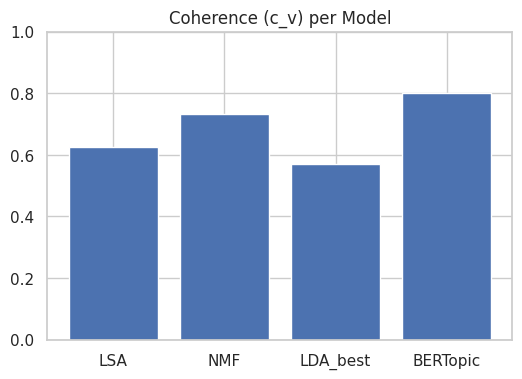

In [ ]:
# ===========================
# 11. Bandingkan coherence antar model
# ===========================
scores = {
    'LSA': lsa_res['coherence'],
    'NMF': nmf_res['coherence'],
    'LDA_best': lda_best['coherence'],
    'BERTopic': bertopic_res['coherence']
}
print("Coherence scores (c_v):")
pprint(scores)

plt.figure(figsize=(6,4))
plt.bar(scores.keys(), scores.values())
plt.ylim(0,1)
plt.title("Coherence (c_v) per Model")
plt.show()

In [ ]:
# ===========================
# 12. Export topics -> CSV dan mapping dokumen -> topic
# ===========================
# Export topics words per model
def export_topics_to_df(topic_list, model_name):
    rows = []
    for idx, words in topic_list:
        rows.append({'model': model_name, 'topic_id': idx, 'top_words': " ".join(words)})
    return pd.DataFrame(rows)

lsa_df_topics = export_topics_to_df(lsa_res['topics'], 'LSA')
nmf_df_topics = export_topics_to_df(nmf_res['topics'], 'NMF')
lda_df_topics = export_topics_to_df(lda_best['topics'], 'LDA_best')

lsa_df_topics.to_csv("lsa_topics.csv", index=False)
nmf_df_topics.to_csv("nmf_topics.csv", index=False)
lda_df_topics.to_csv("lda_topics.csv", index=False)
print("Saved LSA/NMF/LDA topics CSVs.")

# BERTopic: topic info already has top-n tokens, export
bertopic_res['topics'].to_csv("bertopic_topics.csv", index=False)
print("Saved BERTopic topics CSV.")

def assign_lsa_topics(svd_model, doc_latent):
    topic_vectors = svd_model.components_
    assigned = doc_latent.argmax(axis=1)
    return assigned

lsa_assigned = assign_lsa_topics(lsa_res['model'], lsa_res['doc_topic_matrix'])
nmf_assigned = nmf_res['doc_topic_matrix'].argmax(axis=1)
lda_assigned = lda_best['doc_topic'].argmax(axis=1)

export_topic_doc_mapping('LSA', lsa_assigned, df, "doc_topic_mapping_lsa.csv")
export_topic_doc_mapping('NMF', nmf_assigned, df, "doc_topic_mapping_nmf.csv")
export_topic_doc_mapping('LDA', lda_assigned, df, "doc_topic_mapping_lda.csv")

# BERTopic mapping: note if sampled result used, mapping only covers sampled docs
if bertopic_res.get('docs_sampled') is not None:
    sample_docs = bertopic_res['docs_sampled']
    sample_assign = bertopic_res['topics_assignments']
    df_sample_map = pd.DataFrame({'text': sample_docs, 'predicted_topic': sample_assign})
    df_sample_map.to_csv("doc_topic_mapping_bertopic_sample.csv", index=False)
    print("Saved BERTopic doc mapping (sample).")

Saved LSA/NMF/LDA topics CSVs.
Saved BERTopic topics CSV.
Saved mapping to doc_topic_mapping_lsa.csv
Saved mapping to doc_topic_mapping_nmf.csv
Saved mapping to doc_topic_mapping_lda.csv
Saved BERTopic doc mapping (sample).


In [ ]:
# ===========================
# 13. Merge topik mirip (post-processing)
# ===========================
def merge_similar_topics(topic_word_lists, feature_space_vectors=None, threshold=MERGE_SIM_THRESHOLD):
    """
    topic_word_lists: list of lists (each inner is list of words)
    feature_space_vectors: if available, matrix (n_topics x n_terms) for direct cosine sim; otherwise
                           compute topic vectors by averaging word vectors from id2word (not done here).
    Returns: mapping old_topic_id -> new_topic_id and merged topic words
    """
    n = len(topic_word_lists)
    # Build topic-term indicator vectors in vocabulary space (id2word)
    vocab = list(id2word.token2id.keys())
    vocab_index = {w:i for i,w in enumerate(vocab)}
    T = np.zeros((n, len(vocab)))
    for i,words in enumerate(topic_word_lists):
        for w in words:
            if w in vocab_index:
                T[i, vocab_index[w]] += 1
    # normalize
    Tn = normalize(T, norm='l2', axis=1)
    sim = cosine_similarity(Tn)
    # greedy merge
    merged = {}
    new_id = 0
    assigned = set()
    for i in range(n):
        if i in assigned:
            continue
        # find cluster of j where sim[i,j] >= threshold
        cluster = [j for j in range(n) if sim[i,j] >= threshold]
        for j in cluster:
            assigned.add(j)
            merged[j] = new_id
        new_id += 1
    # create merged topics words by union
    merged_topics = {}
    for old, nid in merged.items():
        merged_topics.setdefault(nid, set()).update(topic_word_lists[old])
    merged_topics = {k: sorted(list(v)) for k,v in merged_topics.items()}
    return merged, merged_topics, sim

# Contoh merge untuk LSA topics
topic_words_lsa = lsa_res['topic_words']
merged_map, merged_topics, sim_matrix = merge_similar_topics(topic_words_lsa, threshold=MERGE_SIM_THRESHOLD)
print("Merged topic mapping (old->new):", merged_map)
print("Merged topics (sample):")
for k,v in merged_topics.items():
    print(f"NewTopic {k}: ", ", ".join(v[:12]))

Merged topic mapping (old->new): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Merged topics (sample):
NewTopic 0:  bulan, hasil, hukum, jelas, ketua, masuk, pajak, pihak, rumah, tingkat, transaksi, turut
NewTopic 1:  as, bunga, cnbc, dagang, fed, ihsg, perban, pt, suku, suku bunga, svb, the fed
NewTopic 2:  dunia, fifa, israel, ketua, ketua umum, koalisi, palestina, perindo, piala, piala dunia, timnas, tolak
NewTopic 3:  as, dpr, ivan, ketua, ketua umum, koalisi, komisi, milu, pajak, politik, tppu, transaksi
NewTopic 4:  as, dunia, fifa, israel, palestina, piala, piala dunia, timnas, timnas israel, tolak, tuan, tuan rumah


In [ ]:
# ===========================
# 14. Functions untuk eksperimen otomatis (tuning k, collect coherence)
# ===========================
def tune_k_lsa(docs, vectorizer, k_list):
    results = []
    for k in k_list:
        res = run_lsa(docs, vectorizer, n_topics=k)
        results.append({'k':k, 'coherence': res['coherence'], 'topics': res['topics']})
    return pd.DataFrame(results)

def tune_k_nmf(docs, vectorizer, k_list):
    results = []
    for k in k_list:
        res = run_nmf(docs, vectorizer, n_topics=k)
        results.append({'k':k, 'coherence': res['coherence'], 'topics': res['topics']})
    return pd.DataFrame(results)

In [ ]:
# ===========================
# 15. Ringkasan & catatan
# ===========================
print("Selesai. Ringkasan:")
print(" - LSA coherence:", lsa_res['coherence'])
print(" - NMF coherence:", nmf_res['coherence'])
print(" - LDA best coherence:", lda_best['coherence'], "params:", lda_best['params'])
print(" - BERTopic coherence:", bertopic_res['coherence'])
print("\nHasil topik LSA (contoh):")
print_topics(lsa_res['topics'])

# Simpan environment metadata
meta = {
    'n_docs': len(docs_clean),
    'tfidf_params': TFIDF_PARAMS,
    'count_params': COUNT_PARAMS,
    'lda_grid': LDA_GRID,
    'bertopic_sample': BER_TOPIC_SAMPLE,
    'merge_threshold': MERGE_SIM_THRESHOLD
}
with open("topic_pipeline_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Pipeline metadata saved to topic_pipeline_meta.json")

Selesai. Ringkasan:
 - LSA coherence: 0.6237661957566886
 - NMF coherence: 0.732883658551547
 - LDA best coherence: 0.5709496412371216 params: {'n_components': 10, 'learning_decay': 0.5}
 - BERTopic coherence: 0.7993559171498066

Hasil topik LSA (contoh):
Topic 0: pajak, hukum, bulan, pihak, rumah, ketua, hasil, tingkat, turut, jelas, masuk, transaksi
Topic 1: as, dagang, fed, perban, suku bunga, bunga, svb, suku, the fed, pt, ihsg, cnbc
Topic 2: israel, koalisi, piala dunia, piala, dunia, fifa, ketua umum, perindo, timnas, ketua, palestina, tolak
Topic 3: koalisi, transaksi, pajak, ketua, dpr, as, ketua umum, politik, ivan, milu, komisi, tppu
Topic 4: israel, piala, piala dunia, dunia, fifa, timnas, palestina, tolak, timnas israel, tuan rumah, tuan, as
Pipeline metadata saved to topic_pipeline_meta.json


In [ ]:
import joblib

# ===========================
# 16. Save all models
# ===========================

# Save LSA model
joblib.dump(lsa_res['model'], 'lsa_model.joblib')
print("LSA model saved to lsa_model.joblib")

# Save NMF model
joblib.dump(nmf_res['model'], 'nmf_model.joblib')
print("NMF model saved to nmf_model.joblib")

# Save LDA model
joblib.dump(lda_best['model'], 'lda_model.joblib')
print("LDA model saved to lda_model.joblib")

# Save BERTopic model
bertopic_res['model'].save("bertopic_model", serialization="safetensors")
print("BERTopic model saved to bertopic_model directory")


LSA model saved to lsa_model.joblib
NMF model saved to nmf_model.joblib
LDA model saved to lda_model.joblib
BERTopic model saved to bertopic_model directory


In [ ]:
# ===========================
# 17. Uji coba model dengan data dummy
# ===========================

dummy_data = [
    "Bank sentral umumkan kenaikan suku bunga untuk redam inflasi tinggi",
    "Timnas sepak bola berhasil rebut juara piala dunia setelah mengalahkan Israel",
    "Perusahaan teknologi raksasa berinvestasi besar pada proyek energi terbarukan di kota baru",
    "Korupsi pejabat daerah terbongkar, aparat hukum sita aset miliaran rupiah",
    "Harga bahan pokok terus melonjak menjelang hari raya, masyarakat resah"
]

print("\n--- Data Dummy --- ")
for i, text in enumerate(dummy_data):
    print(f"Dummy {i+1}: {text}")

# Preprocessing data dummy
print("\nPreprocessing data dummy...")
dummy_docs_clean = [preprocess_text(d, do_entity_removal=False) for d in dummy_data]
for i, text in enumerate(dummy_docs_clean):
    print(f"Dummy {i+1} (clean): {text}")

print("\n--- Prediksi Topik per Model ---")

# --- LSA Prediction ---
print("\nLSA Predictions:")
dummy_tfidf = tfidf_vectorizer.transform(dummy_docs_clean)
dummy_lsa_latent = lsa_res['model'].transform(dummy_tfidf)
dummy_lsa_assigned = dummy_lsa_latent.argmax(axis=1)
for i, topic_id in enumerate(dummy_lsa_assigned):
    # Reconstruct topic words for display
    topic_words_str = ", ".join(lsa_res['topics'][topic_id][1])
    print(f"Dummy {i+1}: Topic {topic_id} ({topic_words_str})")

# --- NMF Prediction ---
print("\nNMF Predictions:")
dummy_nmf_latent = nmf_res['model'].transform(dummy_tfidf) # Use tfidf_vectorizer for NMF as well
dummy_nmf_assigned = dummy_nmf_latent.argmax(axis=1)
for i, topic_id in enumerate(dummy_nmf_assigned):
    topic_words_str = ", ".join(nmf_res['topics'][topic_id][1])
    print(f"Dummy {i+1}: Topic {topic_id} ({topic_words_str})")

# --- LDA Prediction ---
print("\nLDA Predictions:")
dummy_count = count_vectorizer.transform(dummy_docs_clean)
dummy_lda_latent = lda_best['model'].transform(dummy_count)
dummy_lda_assigned = dummy_lda_latent.argmax(axis=1)
for i, topic_id in enumerate(dummy_lda_assigned):
    topic_words_str = ", ".join(lda_best['topics'][topic_id][1])
    print(f"Dummy {i+1}: Topic {topic_id} ({topic_words_str})")

# --- BERTopic Prediction ---
print("\nBERTopic Predictions:")
embedder = SentenceTransformer(EMBEDDING_MODEL)
dummy_embeddings = embedder.encode(dummy_docs_clean, show_progress_bar=False, batch_size=64)
dummy_bertopic_topics, _ = bertopic_res['model'].transform(dummy_docs_clean, embeddings=dummy_embeddings)

for i, topic_id in enumerate(dummy_bertopic_topics):
    topic_info = bertopic_res['model'].get_topic(topic_id)
    if topic_info: # Check if topic_id is not -1 (noise)
        topic_words_str = ", ".join([t[0] for t in topic_info[:12]]) # Top 12 words
        print(f"Dummy {i+1}: Topic {topic_id} ({topic_words_str})")
    else:
        print(f"Dummy {i+1}: Topic {topic_id} (Noise/No specific topic assigned)")



--- Data Dummy --- 
Dummy 1: Bank sentral umumkan kenaikan suku bunga untuk redam inflasi tinggi
Dummy 2: Timnas sepak bola berhasil rebut juara piala dunia setelah mengalahkan Israel
Dummy 3: Perusahaan teknologi raksasa berinvestasi besar pada proyek energi terbarukan di kota baru
Dummy 4: Korupsi pejabat daerah terbongkar, aparat hukum sita aset miliaran rupiah
Dummy 5: Harga bahan pokok terus melonjak menjelang hari raya, masyarakat resah

Preprocessing data dummy...
Dummy 1 (clean): sentral umumkan kenaikan suku bunga redam inflasi tinggi
Dummy 2 (clean): timnas sepak bola berhasil rebut juara piala dunia mengalahkan israel
Dummy 3 (clean): perusahaan teknologi raksasa berinvestasi proyek energi terbarukan kota baru
Dummy 4 (clean): pejabat daerah terbongkar aparat hukum sita aset miliaran rupiah
Dummy 5 (clean): bahan pokok terus melonjak menjelang raya resah

--- Prediksi Topik per Model ---

LSA Predictions:
Dummy 1: Topic 1 (as, dagang, fed, perban, suku bunga, bunga, svb, su

2025-11-25 03:13:21,369 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-11-25 03:13:40,707 - BERTopic - Dimensionality - Completed ✓
2025-11-25 03:13:40,708 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-11-25 03:13:40,711 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-11-25 03:13:40,718 - BERTopic - Probabilities - Completed ✓
2025-11-25 03:13:40,719 - BERTopic - Cluster - Completed ✓


Dummy 1: Topic 2 (perban, as, svb, tbk, ekonomi, tumbuh, ihsg, kuat, dagang, pt)
Dummy 2: Topic 3 (israel, piala, dunia, fifa, palestina, timnas, tolak, tuan, stadion, bola)
Dummy 3: Topic -1 (jabat, rupa, baru, pihak, turut, masuk, lanjut, lama, salah, pt)
Dummy 4: Topic -1 (jabat, rupa, baru, pihak, turut, masuk, lanjut, lama, salah, pt)
Dummy 5: Topic 1 (polisi, tangkap, polres, warga, bunuh, inisial, mobil, rumah, aman, polda)


In [ ]:
# ===========================
# 18. Evaluasi Model
# ===========================

import numpy as np
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

models = {
    "LSA": lsa_res,
    "NMF": nmf_res,
    "LDA": lda_best,
    "BERTopic": bertopic_res
}

results = []

# Hitung Topic Diversity
def topic_diversity(top_words):
    all_words = []
    for topic in top_words:
        all_words.extend(topic)
    unique_words = len(set(all_words))
    total_words = len(all_words)
    # Avoid division by zero if total_words is 0
    return unique_words / total_words if total_words > 0 else 0

# Ambil top words untuk setiap model dari dictionary hasil
def get_top_words_from_results(model_name, model_results_dict, n_words=10):
    if model_name == "LSA":
        # lsa_res['topic_words'] already contains list of lists of words
        return [words[:n_words] for words in model_results_dict['topic_words']]
    elif model_name == "NMF":
        # nmf_res['topic_words'] already contains list of lists of words
        return [words[:n_words] for words in model_results_dict['topic_words']]
    elif model_name == "LDA":
        # lda_best['topics'] is [(idx, [word1, word2, ...])]
        return [topic_tuple[1][:n_words] for topic_tuple in model_results_dict['topics']]
    elif model_name == "BERTopic":
        # bertopic_res['topic_words'] already contains list of lists of words
        return [words[:n_words] for words in model_results_dict['topic_words']]
    return []


for name, model_results in models.items(): # Renamed 'model' to 'model_results' for clarity
    print(f"Menghitung evaluasi untuk: {name}")

    # Top words
    # Pass the entire results dictionary for each model
    top_words = get_top_words_from_results(name, model_results)

    # Coherence
    # Use tokenized_texts and id2word which are globally available
    coherence_cv = CoherenceModel(
        topics=top_words,
        texts=tokenized_texts, # Corrected variable name
        dictionary=id2word,      # Corrected variable name
        coherence='c_v'
    ).get_coherence()

    coherence_umass = CoherenceModel(
        topics=top_words,
        texts=tokenized_texts, # Corrected variable name
        dictionary=id2word,      # Corrected variable name
        coherence='u_mass'
    ).get_coherence()

    coherence_uci = CoherenceModel(
        topics=top_words,
        texts=tokenized_texts, # Corrected variable name
        dictionary=id2word,      # Corrected variable name
        coherence='c_uci'
    ).get_coherence()

    # Topic Diversity
    diversity = topic_diversity(top_words)

    results.append({
        "Model": name,
        "Coherence_CV": coherence_cv,
        "Coherence_UMass": coherence_umass,
        "Coherence_UCI": coherence_uci,
        "Topic_Diversity": diversity
    })

results_df = pd.DataFrame(results)
print("\nPerbandingan Metode:")
print(results_df)


Menghitung evaluasi untuk: LSA
Menghitung evaluasi untuk: NMF
Menghitung evaluasi untuk: LDA
Menghitung evaluasi untuk: BERTopic

Perbandingan Metode:
      Model  Coherence_CV  Coherence_UMass  Coherence_UCI  Topic_Diversity
0       LSA      0.635560        -1.714880       0.394949             0.76
1       NMF      0.739320        -1.441611       1.260251             1.00
2       LDA      0.571515        -1.680640       0.450531             0.95
3  BERTopic      0.799356        -1.890982       1.936645             0.90


## Analisis per Model

# LSA
• CV: 0.635560 → Topik cukup koheren namun tidak terlalu kuat

• UMass: −1.714880 → Koherensi dokumen-konteks masih kurang

• UCI: 0.394949 → Relevansi kata dalam topik cukup rendah

• Topic Diversity: 0.76 → Kata antar topik cukup berulang


Interpretasi: LSA cenderung menghasilkan topik yang masih bercampur (topik overlap), karena teknik dekomposisi matriksnya fokus pada dimensi abstrak, bukan pemisahan tema yang jelas.

# NMF

• CV: 0.739320 → Koherensi topik sangat baik

• UMass: −1.441611 → Lebih dekat ke 0 dibanding model lain (lebih baik)

• UCI: 1.260251 → Kualitas asosiasi kata sangat baik

• Topic Diversity: 1.00 → Tidak ada kata tumpang tindih, topik sangat terpisah

Interpretasi:
NMF memberikan pemisahan topik paling jelas dan mudah diinterpretasi, dengan kata yang tidak saling tumpang tindih. Ini menunjukkan bahwa struktur tema dalam berita Indonesia cukup sesuai dengan faktor non-negative decomposition.

#LDA

• CV: 0.571515 → Koherensi paling rendah

• UMass: −1.680640 → Masih relatif rendah kualitas co-occurrence

• UCI: 0.450531 → Semantik kurang kuat

• Topic Diversity: 0.95 → Topik cukup bervariasi

Interpretasi:
LDA menemukan variasi topik cukup baik namun kesatuan maknanya kurang kuat. Hal ini bisa dipengaruhi preprocessing (stopword khusus Indonesia, lemmatization/stemming), atau jumlah topik belum optimal untuk LDA.

# BERTopic

• CV: 0.799356 → Koherensi terbaik antar semua model

• UMass: −1.890982 → Koherensi co-occurrence rendah

• UCI: 1.936645 → Hubungan semantik kata sangat kuat

• Topic Diversity: 0.90 → Keberagaman kata cukup baik


Interpretasi:

BERTopic menangkap konteks semantik secara mendalam berkat embedding transformer, sehingga CV dan UCI sangat tinggi. Namun struktur distribusi kata mungkin lebih kompleks sehingga UMass tidak optimal.

In [ ]:
# Wordcloud
def plot_wordclouds(model_name, top_words):
    # Adjust figsize dynamically based on number of topics
    num_topics = len(top_words)
    if num_topics == 0:
        print(f"No topics to plot for {model_name}")
        return

    cols = min(num_topics, 5) # Max 5 columns for layout
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    # Ensure 'axes' is always a flat iterable of Axes objects
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else: # axes is a single Axes object
        axes = [axes]

    fig.suptitle(f"WordCloud Topik: {model_name}", fontsize=14)

    for i, ax in enumerate(axes):
        if i < num_topics:
            if top_words[i]: # Ensure there are words for the topic
                wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_words[i]))
                ax.imshow(wc, interpolation='bilinear')
                ax.axis("off")
                ax.set_title(f"Topic {i}")
            else:
                ax.axis("off") # Hide empty subplots
                ax.set_title(f"Topic {i} (No words)")
        else:
            ax.axis("off") # Hide empty subplots

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Re-define get_top_words from get_top_words_from_results for use in this cell
def get_top_words(model_name, model_results_dict, n_words=10):
    if model_name == "LSA":
        return [words[:n_words] for words in model_results_dict['topic_words']]
    elif model_name == "NMF":
        return [words[:n_words] for words in model_results_dict['topic_words']]
    elif model_name == "LDA":
        return [topic_tuple[1][:n_words] for topic_tuple in model_results_dict['topics']]
    elif model_name == "BERTopic":
        return [words[:n_words] for words in model_results_dict['topic_words']]
    return []


for name, model_results in models.items():
    print(f"Generating Word Clouds for {name}...")
    top_words = get_top_words(name, model_results)
    plot_wordclouds(name, top_words)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for name in models.keys():
    print(f"\nInterpretasi Topik Model: {name}")
    top_words = get_top_words(name, models[name])
    for i, topic in enumerate(top_words):
        print(f"Topic {i}:", topic)


Interpretasi Topik Model: LSA
Topic 0: ['pajak', 'hukum', 'bulan', 'pihak', 'rumah', 'ketua', 'hasil', 'tingkat', 'turut', 'jelas']
Topic 1: ['as', 'dagang', 'fed', 'perban', 'suku bunga', 'bunga', 'svb', 'suku', 'the fed', 'pt']
Topic 2: ['israel', 'koalisi', 'piala dunia', 'piala', 'dunia', 'fifa', 'ketua umum', 'perindo', 'timnas', 'ketua']
Topic 3: ['koalisi', 'transaksi', 'pajak', 'ketua', 'dpr', 'as', 'ketua umum', 'politik', 'ivan', 'milu']
Topic 4: ['israel', 'piala', 'piala dunia', 'dunia', 'fifa', 'timnas', 'palestina', 'tolak', 'timnas israel', 'tuan rumah']

Interpretasi Topik Model: NMF
Topic 0: ['kota', 'rumah', 'bulan', 'warga', 'ramadhan', 'bakar', 'polisi', 'bantu', 'lama', 'beras']
Topic 1: ['as', 'dagang', 'perban', 'fed', 'suku bunga', 'svb', 'bunga', 'kuat', 'suku', 'the fed']
Topic 2: ['koalisi', 'ketua', 'ketua umum', 'perindo', 'milu', '2024', 'umum', 'politik', 'pdip', 'golkar']
Topic 3: ['pajak', 'transaksi', 'endar', 'harta', 'surat', 'hukum', 'tindak', 'jab